In [14]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
import random
import re
import os

In [16]:
print("Tensorflow Version",tf.__version__)
df = pd.read_csv('train.csv', encoding='latin', header=None)
df.head()

Tensorflow Version 2.18.0


,0,1,2
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [17]:
df.columns = ['sentiment','head','text']
df.head()

,sentiment,head,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [18]:
df = df.drop(['head'], axis=1)

In [19]:
df.head()

,sentiment,text
0,2,This sound track was beautiful! It paints the ...
1,2,I'm reading a lot of reviews saying that this ...
2,2,This soundtrack is my favorite music of all ti...
3,2,I truly like this soundtrack and I enjoy video...
4,2,"If you've played the game, you know how divine..."


In [20]:
lab_to_sentiment = {1:"Negative", 2:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Positive,This sound track was beautiful! It paints the ...
1,Positive,I'm reading a lot of reviews saying that this ...
2,Positive,This soundtrack is my favorite music of all ti...
3,Positive,I truly like this soundtrack and I enjoy video...
4,Positive,"If you've played the game, you know how divine..."


Text(0.5, 1.0, 'Sentiment Data Distribution')

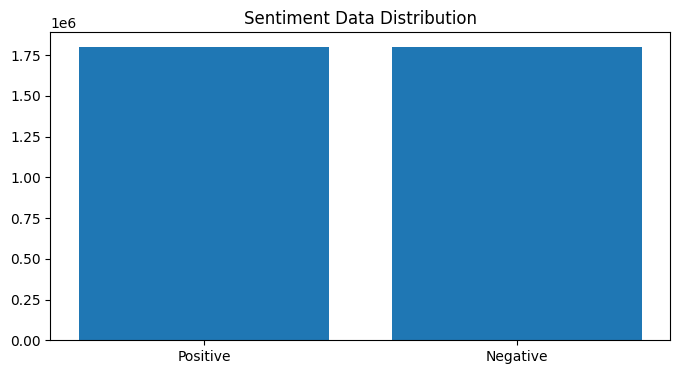

In [21]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [22]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10)

,sentiment,text
1103242,Negative,Any fan of the more recent Alex Cross novels i...
3146694,Negative,I have been a Clive Cussler fan for a long tim...
2042175,Negative,My husband and I enjoy almost all Italian musi...
2972066,Negative,This book has an incredible wealth of informat...
3192800,Negative,"Did not find this book to be useful. The ""PMP:..."
1774759,Negative,I thought this book might have some good insig...
1354970,Positive,I'm a big fan of the show (I guess that means ...
3100599,Negative,Everytime I make a curry dish or one using bee...
756077,Positive,i thought that this movie was funny.It first s...
1660738,Positive,Don't know why people have problems with these...


In [23]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\manik\AppData\Local\Temp\ipykernel_11180\3341848437.py:4: SyntaxWarning: invalid escape sequence '\S'
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [24]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [25]:
df.text = df.text.apply(lambda x: preprocess(x))

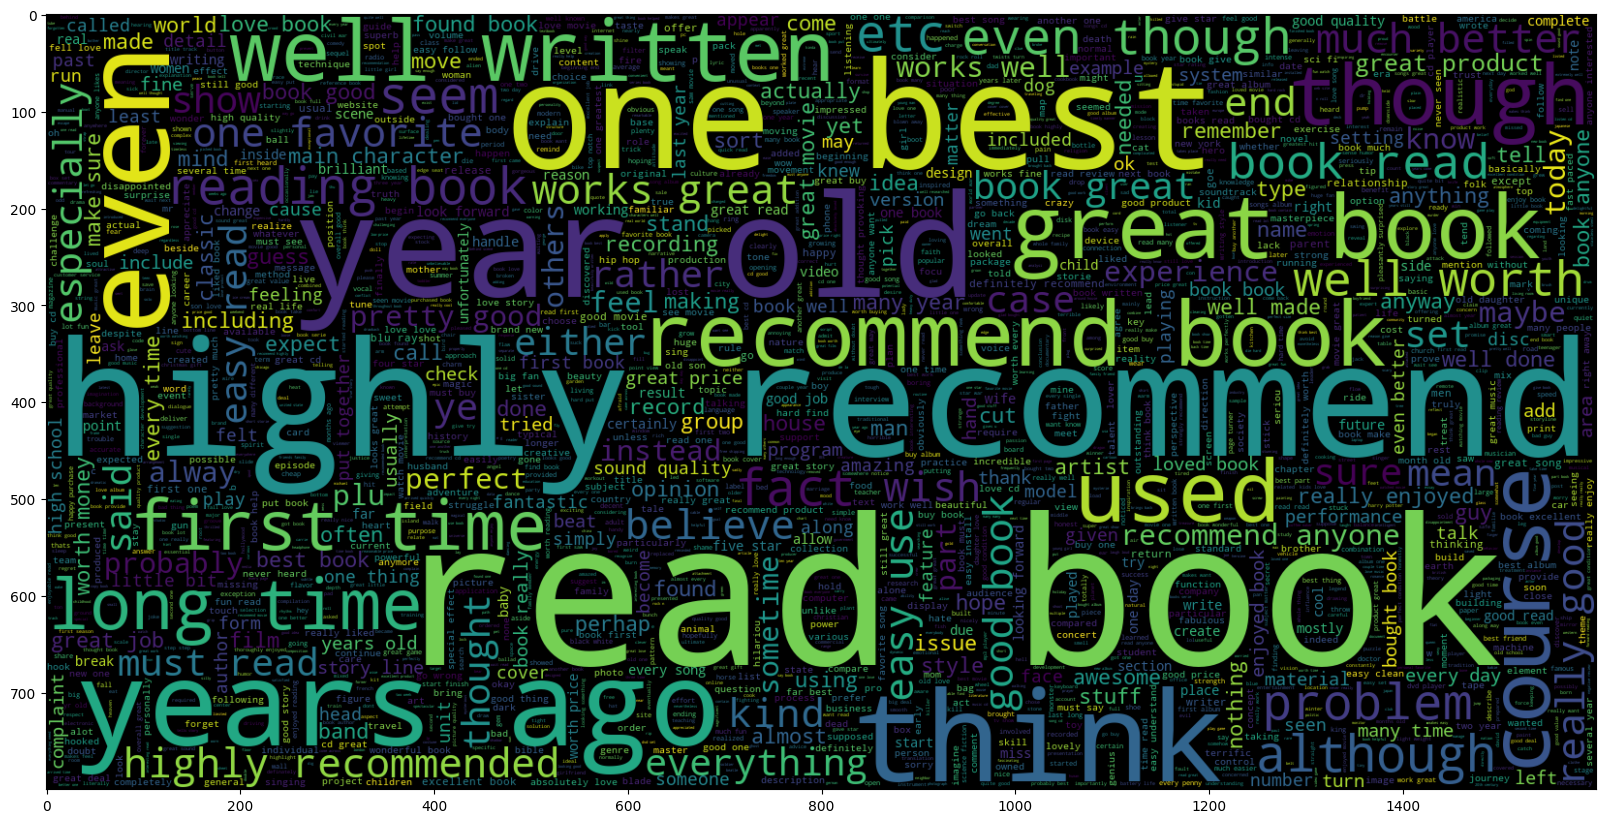

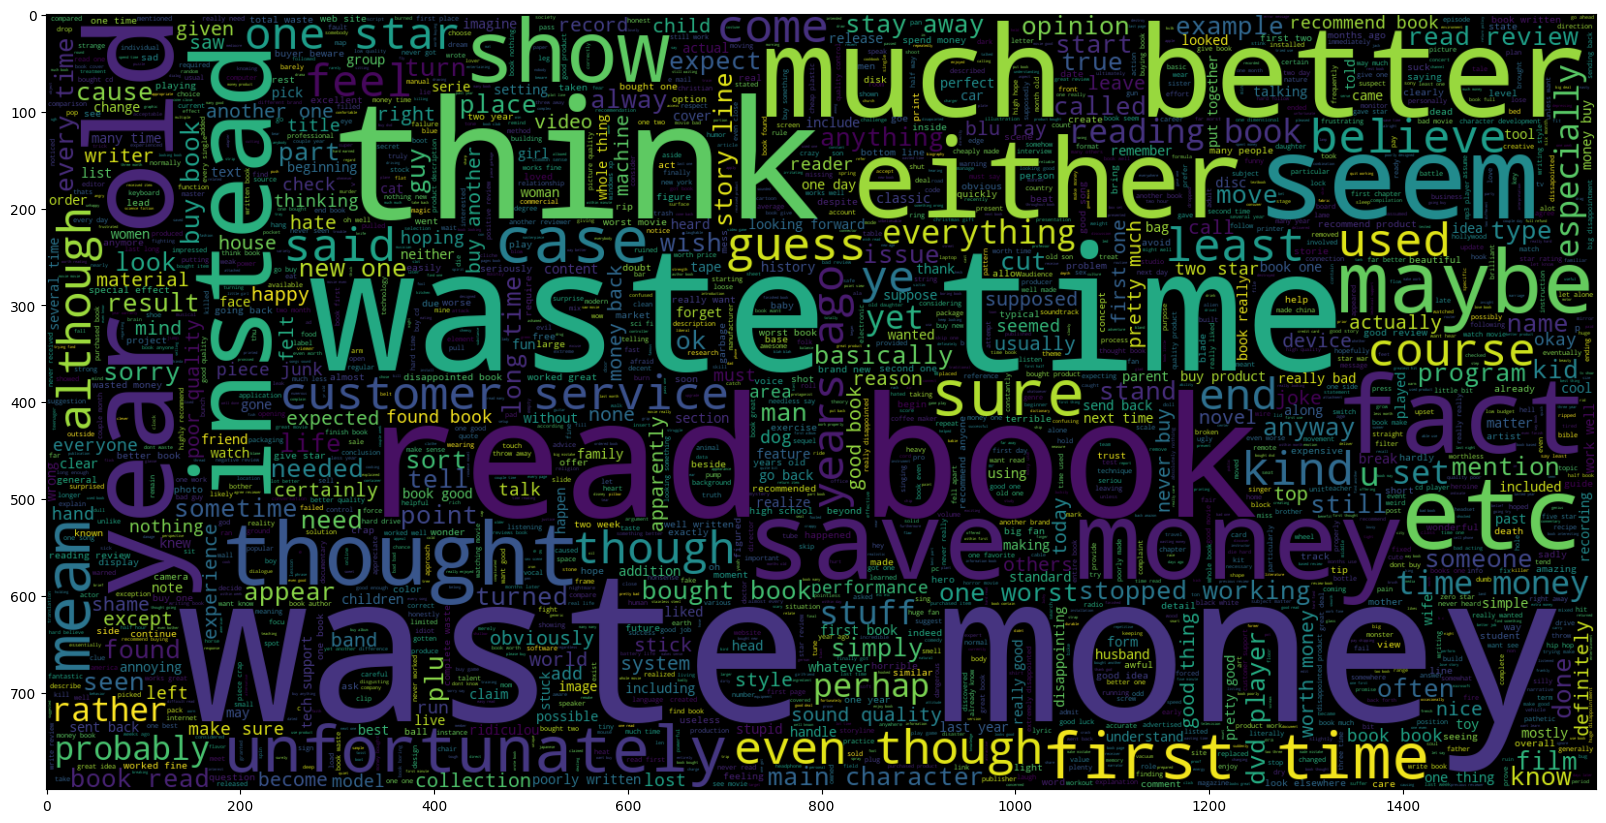

In [26]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')


plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [27]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30


In [28]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 2880000
Test Data size 720000


In [29]:
labels = train_data.sentiment.unique().tolist()

In [30]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (2880000, 1)
y_test shape: (720000, 1)


In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 802452


In [32]:
import pickle

# Save the tokenizer to a file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [33]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (2880000, 30)
Testing X Shape: (720000, 30)


In [34]:
print(x_test)

[[     0      0      0 ...    201    140   1386]
 [ 28853    303    399 ...    281    438   1775]
 [   130   3141 121335 ...     77    263    758]
 ...
 [  1915  19091   1873 ... 293075    203   1056]
 [     0      0      0 ...      1     10  50876]
 [     0      0      0 ...      7   1136   1098]]


In [35]:
import requests
import zipfile
import os

url = "http://nlp.stanford.edu/data/glove.6B.zip"
output_file = "glove.6B.zip"
response = requests.get(url, stream=True)
with open(output_file, "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)
print("Download complete!")
with zipfile.ZipFile(output_file, "r") as zip_ref:
    zip_ref.extractall("glove")
print("Extraction complete!")
os.remove(output_file)
print("Cleaned up zip file.")

In [36]:
GLOVE_EMB = 'glove.6B.300d.txt'

EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'


In [37]:
embeddings_index = {}

f =  open(GLOVE_EMB,encoding='utf-8')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [38]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [39]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

c:\Users\manik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [41]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [43]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


In [44]:

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 354s 124ms/step - accuracy: 0.7995 - loss: 0.4261 - val_accuracy: 0.8538 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 2/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 336s 119ms/step - accuracy: 0.8447 - loss: 0.3507 - val_accuracy: 0.8625 - val_loss: 0.3177 - learning_rate: 0.0010
Epoch 3/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 330s 117ms/step - accuracy: 0.8526 - loss: 0.3369 - val_accuracy: 0.8658 - val_loss: 0.3113 - learning_rate: 0.0010
Epoch 4/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 326s 116ms/step - accuracy: 0.8555 - loss: 0.3303 - val_accuracy: 0.8684 - val_loss: 0.3048 - learning_rate: 0.0010
Epoch 5/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 326s 116ms/step - accuracy: 0.8581 - loss: 0.3250 - val_accuracy: 0.8704 - val_loss: 0.3044 - learning_rate: 0.0010
Epoch 6/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 332s 118ms/step - accuracy: 0.8598 - loss: 0.3213 - val_accuracy: 0.8707 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 7/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 330s 117ms

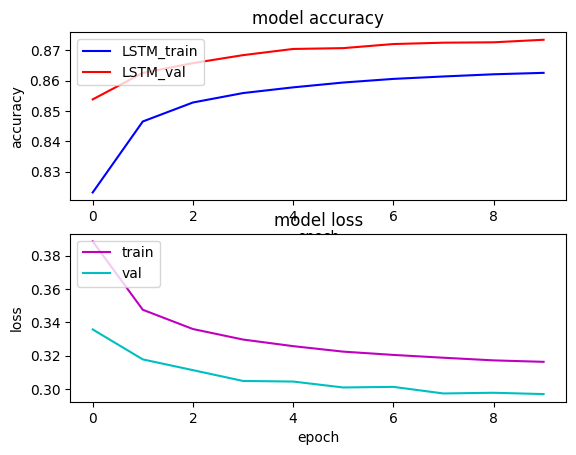

In [45]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [46]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step


In [47]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

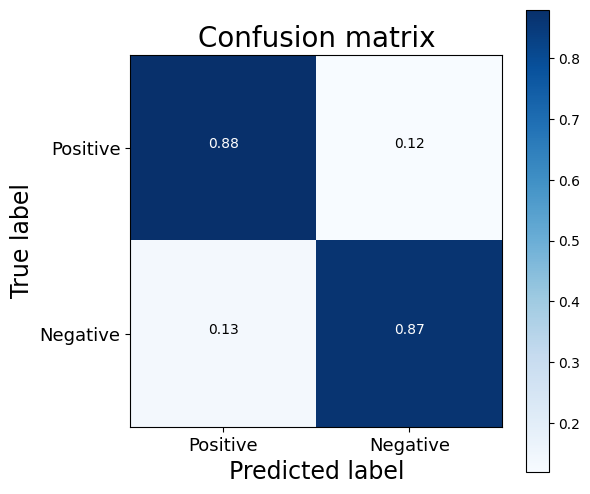

In [48]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [49]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87    360049
    Positive       0.88      0.87      0.87    359951

    accuracy                           0.87    720000
   macro avg       0.87      0.87      0.87    720000
weighted avg       0.87      0.87      0.87    720000



In [50]:
df.shape

(3600000, 2)

In [51]:
df['sentiment'].value_counts()

sentiment
Positive    1800000
Negative    1800000
Name: count, dtype: int64

In [52]:
from nltk.stem import PorterStemmer
port_steam = PorterStemmer()

In [53]:
def stemming(content):
    stemmer = nltk.SnowballStemmer('english')
    stemmed_content = content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [54]:
X = df['text'].values
Y = df['sentiment'].values

In [55]:
print(X)

['sound track beautiful paints senery mind well would recomend even people hate vid game music played game chrono cross games ever played best music backs away crude keyboarding takes fresher step grate guitars soulful orchestras would impress anyone cares listen'
 'reading lot reviews saying best game soundtrack figured write review disagree bit opinino yasunori mitsuda ultimate masterpiece music timeless listening years beauty simply refuses fade price tag pretty staggering must say going buy cd much money one feel would worth every penny'
 'soundtrack favorite music time hands intense sadness prisoners fate means played game hope distant promise girl stole star important inspiration personally throughout teen years higher energy tracks like chrono cross time scar time dreamwatch chronomantique indefinably remeniscent chrono trigger absolutely superb well soundtrack amazing music probably best composer work heard xenogears soundtrack say sure even never played game would worth twice 

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [57]:
print(X.shape, X_train.shape, X_test.shape)

(3600000,) (2880000,) (720000,)


In [58]:
print(X_train)
print(Y_train)

['product received pictured described however received reel damaged hose rough guide roller may going back'
 'loren coleman jerome clark book cryptozoology z informative encyclopedia clearly simply states facts cryptids animals interest cryptozoologists investigate study animals books deal much ore detail specific cryptids whose interest subject cryptozoology still basic stage find book helpful starting interesting fun hobby calling'
 'book sophmoric version dunnit always read book one sitting took 3 days get one even though skipped boring pages author spends many chapters setting character character yet still points actions recognize conservative person something conservative everytime something within character important plot read sophisticated books 4th grade'
 ...
 'ordered several bottles personally use given christmas gift dad also loved used everyday'
 'cd ok one week done ok fell asleep dont waste money'
 'saw film cinema bored mind terrible terrible bland performances involved

In [59]:
print(X_train)

['product received pictured described however received reel damaged hose rough guide roller may going back'
 'loren coleman jerome clark book cryptozoology z informative encyclopedia clearly simply states facts cryptids animals interest cryptozoologists investigate study animals books deal much ore detail specific cryptids whose interest subject cryptozoology still basic stage find book helpful starting interesting fun hobby calling'
 'book sophmoric version dunnit always read book one sitting took 3 days get one even though skipped boring pages author spends many chapters setting character character yet still points actions recognize conservative person something conservative everytime something within character important plot read sophisticated books 4th grade'
 ...
 'ordered several bottles personally use given christmas gift dad also loved used everyday'
 'cd ok one week done ok fell asleep dont waste money'
 'saw film cinema bored mind terrible terrible bland performances involved

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [61]:
print(type(X_train))

<class 'numpy.ndarray'>


In [62]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [63]:
print(X_test)

  (0, 57144)	0.3479429811030813
  (0, 147152)	0.22877177297545712
  (0, 185498)	0.19110739452206713
  (0, 231958)	0.3689540466614656
  (0, 252454)	0.1699619017461229
  (0, 265390)	0.24900612346782813
  (0, 295324)	0.12140091673336538
  (0, 340789)	0.19863052506756948
  (0, 371555)	0.23740047117113403
  (0, 372807)	0.2554369028821164
  (0, 382388)	0.1729804902755347
  (0, 420503)	0.06949074675084092
  (0, 438104)	0.09773964108661631
  (0, 523068)	0.1704100723165337
  (0, 606601)	0.385549929469959
  (0, 628406)	0.22248023712069742
  (0, 629349)	0.12120914789023553
  (0, 657487)	0.22618363018998255
  (0, 771589)	0.12162462470396741
  (0, 786272)	0.1874203370791847
  (1, 213350)	0.4294835730962369
  (1, 469111)	0.16401298419789095
  (1, 508638)	0.1033074619808296
  (1, 569861)	0.19018076903459744
  (1, 637832)	0.340313968810202
  :	:
  (719999, 45417)	0.22840506226777116
  (719999, 51410)	0.2267104873904253
  (719999, 66363)	0.3086278154142303
  (719999, 83894)	0.2652416187515724
  (719999

In [64]:
print(X_train)

  (0, 562012)	0.1469037923961893
  (0, 584115)	0.39150658800731014
  (0, 540800)	0.30818273575274324
  (0, 206658)	0.25533282188951906
  (0, 348927)	0.16677050207327881
  (0, 587920)	0.3552696523003553
  (0, 193573)	0.2882047056261522
  (0, 347669)	0.30462920066604604
  (0, 609604)	0.28991608200933106
  (0, 321646)	0.23927527097910997
  (0, 607304)	0.3315136940344107
  (0, 447813)	0.18167301827481042
  (0, 311325)	0.16967783389356514
  (0, 86730)	0.14859212024700655
  (1, 428342)	0.18209472491239367
  (1, 163010)	0.1508231662731707
  (1, 385234)	0.17156732783951426
  (1, 157430)	0.13941828996843972
  (1, 113999)	0.08278748783121266
  (1, 187802)	0.42743631977981805
  (1, 366108)	0.1095522263416502
  (1, 247387)	0.1486498047723043
  (1, 158506)	0.09938064084845089
  (1, 645553)	0.08541319348786619
  (1, 672200)	0.10847055398481813
  :	:
  (2879999, 785897)	0.10213014385445504
  (2879999, 487865)	0.11869314470688695
  (2879999, 155463)	0.2922272062293271
  (2879999, 115661)	0.11786597323

In [65]:
import pickle

# Save the model
filename = 'trained_model_amazonB.sav'
pickle.dump(model, open(filename, 'wb'))



In [66]:
# loading the saved model
loaded_model = pickle.load(open('trained_model_amazonB.sav', 'rb'))

In [67]:
def preprocess(text, stem=False):
    text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\manik\AppData\Local\Temp\ipykernel_11180\1460555962.py:2: SyntaxWarning: invalid escape sequence '\S'
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [68]:
custom_text = "I really love this product! It’s amazing."

# Preprocess the text
cleaned_text = preprocess(custom_text)

# Tokenize and pad the text
custom_text_sequence = tokenizer.texts_to_sequences([cleaned_text])  # Tokenize
custom_text_padded = pad_sequences(custom_text_sequence, maxlen=MAX_SEQUENCE_LENGTH)  # Pad

In [69]:
score = model.predict(custom_text_padded)

# Decode the sentiment
predicted_sentiment = decode_sentiment(score[0][0])

# Output the result
print(f"Custom Text: {custom_text}")
print(f"Predicted Sentiment: {predicted_sentiment} (Score: {score[0][0]})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
Custom Text: I really love this product! It’s amazing.
Predicted Sentiment: Positive (Score: 0.9732790589332581)


In [70]:
# Load the tokenizer from the file
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def predict_sentiment(custom_text, tokenizer, model, max_sequence_length=50):
    # Preprocess the input text
    cleaned_text = preprocess(custom_text)

    # Tokenize and pad the input text to match model input
    custom_text_sequence = tokenizer.texts_to_sequences([cleaned_text])
    custom_text_padded = pad_sequences(custom_text_sequence, maxlen=max_sequence_length)

    # Predict sentiment
    score = model.predict(custom_text_padded)

    # Decode the sentiment
    pos_score = score[0][0]
    neg_score = 1 - score[0][0]

    positive_percent =  pos_score * 100
    negitive_percent =  neg_score * 100

    def decode_sentiment(score):
        return "Positive" if score > 0.5 else "Negative"

    predicted_sentiment = decode_sentiment(score[0][0])

    # Output the result
    return {
        'custom_text': custom_text,
        'predicted_sentiment': predicted_sentiment,
        'positive_percent': positive_percent,
        'negitive_percent' : negitive_percent
    }

In [71]:
# custom_input = "The product arrived on time, and the packaging was great, but it doesn’t work as advertised. Really disappointed. 😕 #MixedFeelings"
custom_input ="i love you my country"
result = predict_sentiment(custom_input, tokenizer, model)
 
print(f"input: {result['custom_text']}")
print(f"output: {result['predicted_sentiment']}")
print(f"Percent positive : {result['positive_percent']:.2f}%")
print(f"Percent negative : {result['negitive_percent']:.2f}%")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
input: i love you my country
output: Positive
Percent positive : 74.70%
Percent negative : 25.30%
